In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.2.0+cu118


In [2]:
# importing data onto Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

# CNN

### Prepare Data for CNN in PyTorch

In [3]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [4]:
PRECT = pd.read_csv('Detrended_PRECT.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [5]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [6]:
y = y.reshape(-1, 3)
y = y[:, 0]
y.shape

(7400,)

In [7]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [8]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [9]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [10]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 1])
torch.Size([10, 74, 1])
torch.Size([10, 74, 1])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [12]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


### Build CNN

In [34]:
6*9*32*128

221184

In [51]:
class Net(nn.Module):
    def __init__(self, p):
        super(Net, self).__init__()
        self.p = p
        self.conv1 = nn.Conv2d(1, 64, stride = (2,2), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 9, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 16 * 6 * 9)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1)
model

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=864, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [42]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

81201

### Train CNN

In [18]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        #X = X.to(device_cuda, non_blocking=True)
        #y = y.to(device_cuda, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            #X = X.to(device_cuda, non_blocking=True)
            #y = y.to(device_cuda, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

#### Hyperparameter Tuning

In [54]:
# Hyperparameter Tuning Loop
import torch.optim as optim

tuning_valid_losses = []

for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
            
            model = Net(p)
            valid_losses = []

            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # 5 epochs didn't give any of them enough to learn anything. Maybe do 10-20?
            epochs = 20
            print(f"Learning Rate: {lr}\nDropout Probability: {p}")
            for t in range(epochs):

                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(dataloader_train, model, loss_fn, optimizer)
                test_valid_loop(dataloader_valid, model, loss_fn)

            # Should we pick the best validation loss or just the most recent?
            
            # Most Recent:
            # tuning_valid_losses.append((valid_losses[epochs -1 ], lr, p))
            
            # Best:
            best_valid_loss = max(valid_losses)

            tuning_valid_losses.append((best_valid_loss, lr, p))
            
print("Done!\n")



Epoch 1
-------------------------------
loss: 17.679295  [   32/ 5920]
loss: 20.344669  [ 1184/ 5920]
loss: 21.191616  [ 2336/ 5920]
loss: 8.987180  [ 3488/ 5920]
loss: 14.809383  [ 4640/ 5920]
loss: 21.782190  [ 5792/ 5920]
Validation Loss: 22.281891 

Done!
Epoch 1
-------------------------------
loss: 23.913023  [   32/ 5920]
loss: 24.654837  [ 1184/ 5920]
loss: 27.472038  [ 2336/ 5920]
loss: 16.195875  [ 3488/ 5920]
loss: 33.470428  [ 4640/ 5920]
loss: 15.944049  [ 5792/ 5920]
Validation Loss: 21.929003 

Done!
Epoch 1
-------------------------------
loss: 32.400631  [   32/ 5920]
loss: 14.101193  [ 1184/ 5920]
loss: 18.609407  [ 2336/ 5920]
loss: 14.613054  [ 3488/ 5920]
loss: 39.057388  [ 4640/ 5920]
loss: 29.016811  [ 5792/ 5920]
Validation Loss: 21.966861 

Done!
Epoch 1
-------------------------------
loss: 23.997990  [   32/ 5920]
loss: 23.557852  [ 1184/ 5920]
loss: 31.204109  [ 2336/ 5920]
loss: 20.761658  [ 3488/ 5920]
loss: 17.176756  [ 4640/ 5920]
loss: 39.968613  [ 5792

In [55]:
tuning_valid_losses

[(22.281890749931335, 0.1, 0.1),
 (21.929002563158672, 0.1, 0.2),
 (21.96686053276062, 0.01, 0.1),
 (21.974591573079426, 0.01, 0.2)]

In [56]:
# Pull out best lr and p from above

best_loss = np.inf
for loss, lr, p in tuning_valid_losses:
    if loss < best_loss:
        best_loss = loss
        tuned_lr = lr
        tuned_p = p

print(f"Optimal Learning Rate: {tuned_lr}\nOptimal Dropout Probability: {tuned_p}")

Optimal Learning Rate: 0.1
Optimal Dropout Probability: 0.2


#### Training with best lr and p

In [68]:
# Train model and evaluate on validation set for each epoch

model = Net(tuned_p)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 500

best_loss = np.inf
patience = 10
no_improvement_counter = 0

for t in range(epochs):
    
    if no_improvement_counter >= patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 13.855873  [   32/ 5920]
loss: 20.191210  [ 1184/ 5920]
loss: 28.033836  [ 2336/ 5920]
loss: 22.950500  [ 3488/ 5920]
loss: 25.039824  [ 4640/ 5920]
loss: 24.142462  [ 5792/ 5920]
Validation Loss: 21.960091 

Epoch 2
-------------------------------
loss: 27.874249  [   32/ 5920]
loss: 20.799038  [ 1184/ 5920]
loss: 16.269957  [ 2336/ 5920]
loss: 18.022537  [ 3488/ 5920]
loss: 31.579508  [ 4640/ 5920]
loss: 23.198883  [ 5792/ 5920]
Validation Loss: 21.958204 

Epoch 3
-------------------------------
loss: 25.160267  [   32/ 5920]
loss: 26.286116  [ 1184/ 5920]
loss: 20.582865  [ 2336/ 5920]
loss: 21.414722  [ 3488/ 5920]
loss: 21.749815  [ 4640/ 5920]
loss: 27.209240  [ 5792/ 5920]
Validation Loss: 21.957083 

Epoch 4
-------------------------------
loss: 16.468330  [   32/ 5920]
loss: 14.853720  [ 1184/ 5920]
loss: 22.800529  [ 2336/ 5920]
loss: 13.449794  [ 3488/ 5920]
loss: 24.319622  [ 4640/ 5920]
loss: 42.340225  [ 5792/ 5920]
Validatio

### Evaluate CNN

In [69]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2



actual_values = np.array(y_test.squeeze(1))

# Instantiate model
model_best_weights = Net(tuned_p)

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

# Set the model to evaluation mode
model_best_weights.eval()
#model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1)).squeeze(1).detach().numpy()
#predicted_values = model(X_test.unsqueeze(1)).squeeze(1).detach().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

R-squared: -3.3020973205566406e-05


In [70]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)
#test_valid_loop(dataloader_test, model, loss_fn, valid = False)

Test Loss: 22.266819 



In [71]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


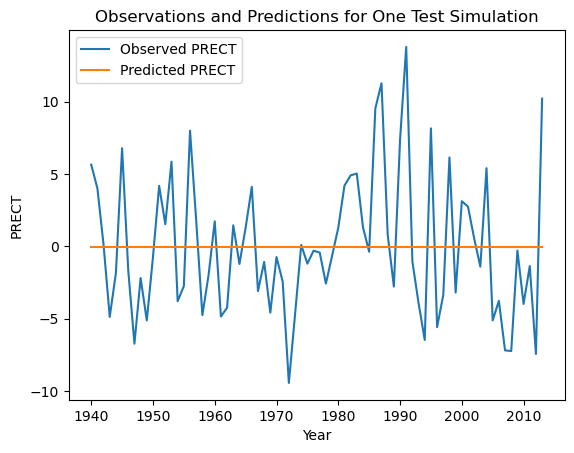

In [72]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

In [73]:
train_loss_dict = dict()

valid_loss_dict = dict()

for i in range(len(train_losses)):
    train_loss_dict[i+1] = train_losses[i]
    valid_loss_dict[i+1] = valid_losses[i]

IndexError: list index out of range

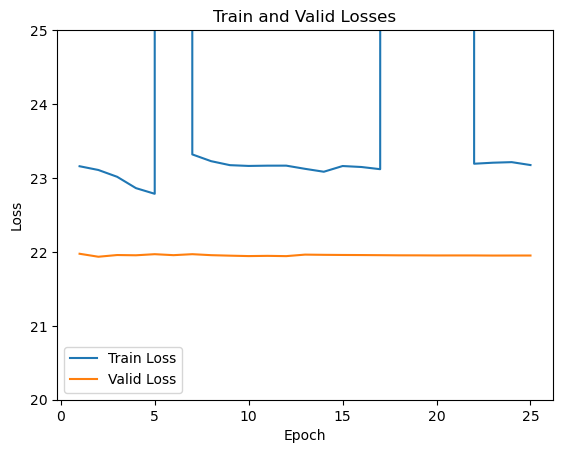

In [74]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')
plt.ylim(20, 25)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()